In [1]:
# -------------------------------------------------------------
# TRANSACTION ANOMALY DETECTION — AUTOENCODER
# -------------------------------------------------------------

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# -------------------------------------------------------------
# 1. Load preprocessed transaction features
# -------------------------------------------------------------

df = pd.read_csv("transaction_features.csv")
print("Loaded transaction features:", df.shape)

# -------------------------------------------------------------
# 2. Handle missing values
# -------------------------------------------------------------

imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(df)
joblib.dump(imputer, "transaction_autoencoder_imputer.pkl")
print("Missing values imputed and imputer saved.")


Loaded transaction features: (2512, 21)
Missing values imputed and imputer saved.


In [2]:
# -------------------------------------------------------------
# 3. Scale features
# -------------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "transaction_autoencoder_scaler.pkl")
print("Features scaled and scaler saved.")

Features scaled and scaler saved.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 21)             │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 566 (2.21 KB)

 Trainable params: 566 (2.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
36/36 - 1s - 34ms/step - loss: 1.0534 - val_loss: 0.8915
Epoch 2/50
36/36 - 0s - 4ms/step - loss: 1.0055 - val_loss: 0.8711
Epoch 3/50
36/36 - 0s - 4ms/step - loss: 0.9851 - val_loss: 0.8570
Epoch 4/50
36/36 - 0s - 4ms/step - loss: 0.9695 - val_loss: 0.8434
Epoch 5/50
36/36 - 0s - 4ms/step - loss: 0.9519 - val_loss: 0.8280
Epoch 6/50
36/36 - 0s - 3ms/step - loss: 0.9349 - val_loss: 0.8126
Epoch 7/50
36/36 - 0s - 4ms/step - loss: 0.9176 - val_loss: 0.7975
Epoch 8/50
36/36 - 0s - 4ms/step - loss: 0.9005 - val_loss: 0.7842
Epoch 9/50
36/36 - 0s - 3ms/step - loss: 0.8848 - val_loss: 0.7729
Epoch 10/50
36/36 - 0s - 4ms/step - loss: 0.8703 - val_loss: 0.7633
Epoch 11/50
36/36 - 0s - 4ms/step - loss: 0.8576 - val_loss: 0.7550
Epoch 12/50
36/36 - 0s - 4ms/step - loss: 0.8462 - val_loss: 0.7490
Epoch 13/50
36/36 - 0s - 5ms/step - loss: 0.8336 - val_loss: 0.7413
Epoch 14/50
36/36 - 0s - 4ms/step - loss: 0.8228 - val_loss: 0.7319
Epoch 15/50
36/36 - 0s - 4ms/step - loss: 0.8126 - val_l

Autoencoder model saved: transaction_autoencoder_model.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Anomalies detected: 76 / 2512
Anomaly threshold (97 percentile) = 1.72317


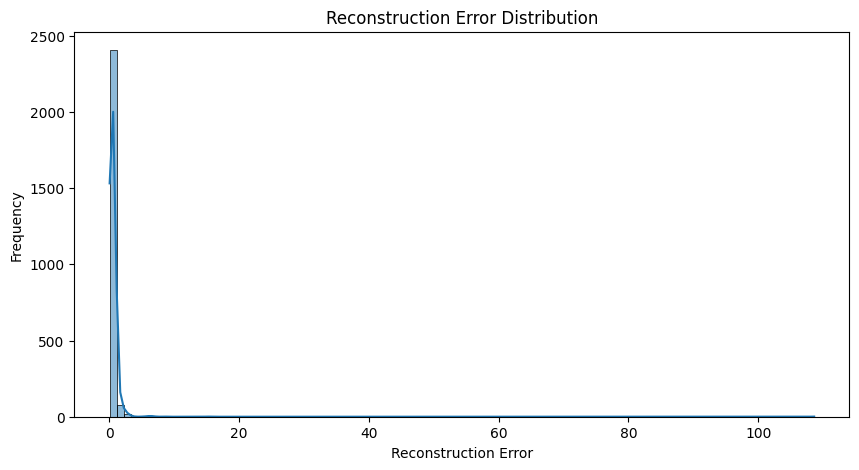

In [ ]:
# -------------------------------------------------------------
# 4. Build Autoencoder model
# -------------------------------------------------------------

input_dim = X_scaled.shape[1]
encoding_dim = max(5, input_dim // 2)  # simple heuristic

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(encoding_dim // 2, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

autoencoder.summary()

# -------------------------------------------------------------
# 5. Train Autoencoder
# -------------------------------------------------------------

history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    verbose=2
)

# Save trained model
autoencoder.save("transaction_autoencoder_model.h5", compile=False)
print("Autoencoder model saved: transaction_autoencoder_model.h5")

# -------------------------------------------------------------
# 6. Generate reconstruction errors
# -------------------------------------------------------------

X_pred = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean(np.square(X_scaled - X_pred), axis=1)

df_results = df.copy()
df_results["reconstruction_error"] = reconstruction_errors

# -------------------------------------------------------------
# 7. Define anomaly threshold
# -------------------------------------------------------------

# You can tune this percentile as desired
threshold = np.percentile(reconstruction_errors, 97)  # top 3% anomalies
df_results["is_anomaly"] = (df_results["reconstruction_error"] > threshold).astype(int)

print("\nAnomalies detected:", df_results["is_anomaly"].sum(), "/", len(df_results))
print(f"Anomaly threshold (97 percentile) = {threshold:.5f}")

# -------------------------------------------------------------
# 8. Plot reconstruction error distribution
# -------------------------------------------------------------

plt.figure(figsize=(10,5))
sns.histplot(df_results["reconstruction_error"], bins=100, kde=True)
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()


In [4]:
# -------------------------------------------------------------
# 9. Show top anomalies
# -------------------------------------------------------------

top_n = 20
print(f"\nTop {top_n} most anomalous transactions:")
print(df_results.sort_values("reconstruction_error", ascending=False).head(top_n))

# -------------------------------------------------------------
# 10. Save results
# -------------------------------------------------------------

df_results.to_csv("transaction_autoencoder_predictions.csv", index=False)
print("\nSaved: transaction_autoencoder_predictions.csv")


Top 20 most anomalous transactions:
      TransactionAmount      hour  day_of_week       day  time_since_last  \
569           -0.945923 -0.856729     1.026963 -1.350210        -0.736376   
6              0.334259 -0.856729    -0.958464  0.933013         0.373086   
1778           1.745108  0.511423    -0.296655 -1.007726        -0.201761   
2222          -0.676025  0.511423    -0.958464 -0.665243        -0.951822   
670            1.992737  0.511423    -0.296655 -1.007726        -0.949599   
5             -0.115126 -0.856729    -0.296655  0.019724        -0.865504   
1909          -0.541522  0.511423    -0.958464 -0.779404        -0.351895   
1969          -0.467624  0.511423    -0.958464 -0.665243        -0.950281   
2008           0.010333  0.511423    -0.958464 -1.692693         1.397904   
2330           1.240599 -0.856729     1.688773 -1.236049        -0.739236   
2299           2.484364 -0.856729     1.026963  0.362207        -0.736346   
111            1.047101  0.511423     1